In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import sys
sys.path.insert(0,'C:/Users/이세령/picasso/KOSDAQ-Gap-Strategy/CODE')
import mylib as my
matplotlib.rc('font', family='Malgun Gothic',size=8, weight = 'bold')

In [13]:
KOSDAQTIK = pd.read_excel('C:/Users/이세령/picasso/KOSDAQ-Gap-Strategy/DATA/KOSDAQTIK.xlsx', header=2)


In [14]:
KOSDAQTIK.head()

,Date,OPEN,LAST_PRICE
0,2017-06-30 09:00:00,665.67,665.78
1,2017-06-30 09:05:00,665.71,667.36
2,2017-06-30 09:10:00,667.45,667.60
3,2017-06-30 09:15:00,667.49,667.64
4,2017-06-30 09:20:00,667.70,667.49


In [15]:
KOSDAQTIK.dtypes

Date          datetime64[ns]
OPEN                 float64
LAST_PRICE           float64
dtype: object

In [16]:
KOSDAQTIK['hour'] = KOSDAQTIK.Date.dt.hour

In [17]:
KOSDAQTIK['minute'] = KOSDAQTIK.Date.dt.minute

In [18]:
KOSDAQTIK['Date'].dt.day.head()

0    30
1    30
2    30
3    30
4    30
Name: Date, dtype: int64

In [19]:
buy = KOSDAQTIK[(KOSDAQTIK.hour.between(15,15)) & (KOSDAQTIK.minute.between(30,30))].OPEN

In [20]:
buy.head()

78     669.10
157    661.44
236    656.67
315    661.46
394    663.97
Name: OPEN, dtype: float64

In [21]:
%matplotlib inline

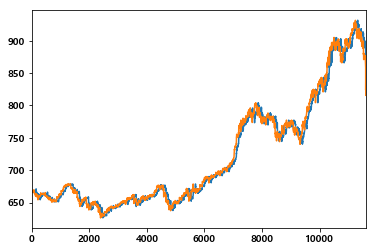

In [22]:
KOSDAQTIK.OPEN.shift(79).plot()
KOSDAQTIK.LAST_PRICE.plot()

In [23]:
sell = KOSDAQTIK[(KOSDAQTIK.hour <= 9) & (KOSDAQTIK.minute.between(0,0))].OPEN

In [24]:
sell.head()

0      665.67
79     671.17
158    662.17
237    657.70
316    663.79
Name: OPEN, dtype: float64

In [25]:
buy.head()

78     669.10
157    661.44
236    656.67
315    661.46
394    663.97
Name: OPEN, dtype: float64

In [26]:
KOSDAQTIK['buy'] = buy

In [27]:
KOSDAQTIK['sell'] = sell

In [28]:
KOSDAQTIK['buy'].dropna().head()

78     669.10
157    661.44
236    656.67
315    661.46
394    663.97
Name: buy, dtype: float64

In [29]:
s = KOSDAQTIK['sell'].dropna()

In [30]:
s.head()

0      665.67
79     671.17
158    662.17
237    657.70
316    663.79
Name: sell, dtype: float64

In [31]:
gain = pd.Series((sell.values*0.99985-buy.values*1.00015)/buy.values*1.00015)

ValueError: operands could not be broadcast together with shapes (145,) (147,) 

In [ ]:
(1+gain).cumprod().plot()

In [ ]:
(1+gain).cumprod().tail()

In [ ]:
len(gain[gain>0])/len(gain)

In [ ]:
gain.mean()

In [ ]:
gain.plot()

In [ ]:
KOSDAQTIK.head()

In [ ]:
def bet(data):
    start = 0.1
    cir = 0
    max_cir = 8
    list = []
    for i in range(len(data)):
        if data.values[i-1]==True and cir <= max_cir:
            cir +=1
            weight = start*cir
        else:
            cir = 1
            weight = start*cir
        list.append(weight)
    return list

In [ ]:
def bet2(data):
    start = 0.1
    cir = 0
    max_cir = 8
    min_cir = 1
    list = []
    for i in range(len(data)):
        if cir <= 1:
            cir +=1
            weight = start*cir
        elif data.values[i-1]==True and cir <= max_cir:
            cir +=1
            weight = start*cir
        elif data.values[i-1]==False and cir <= max_cir:
            cir -= 1
            weight = start*cir
        else:
            cir = min_cir
            weight = start*cir
        list.append(weight)
    return list

In [ ]:
def cash_weight(data):
    list=[]
    for i in data:
        cash = (1-i)*0.003835/100
        list.append(cash)
    return list

In [ ]:
gain

In [ ]:
new = bet(gain>0)*gain + cash_weight(bet(gain>0))

In [ ]:
new2 = bet2(gain>0)*gain + cash_weight(bet2(gain>0))

In [ ]:
(1+new).cumprod().tail()

In [ ]:
(1+new2).cumprod().tail()

In [ ]:
KOSDAQTIK['종가지수'] = KOSDAQTIK.LAST_PRICE

In [ ]:
KOSDAQTIK['날짜'] = KOSDAQTIK.Date

In [ ]:
ben = my.벤치마크( KOSDAQTIK[(KOSDAQTIK.hour.between(15,15)) & (KOSDAQTIK.minute.between(30,30))])

In [ ]:
ben.index = new.index

In [ ]:
ben.values[-1]

In [ ]:
a = (1+gain).cumprod()
b = (1+new).cumprod()
c = (1+new2).cumprod()
e = ben
d = pd.concat([a, b, c, e], axis=1).dropna()
d.columns = ['종가베팅', '현금혼합비중조절', '현금혼합비중조절2', '벤치마크']
d.divide(d.iloc[0]).plot(figsize = (18,12))
plt.show()

최대하락 = d.현금혼합비중조절.rolling(min_periods=1, window = 500).max()
당월하락 = d.현금혼합비중조절/최대하락 - 1.0
최대하락폭 = 당월하락.rolling(min_periods=1, window=500).min()

당월하락.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

최대하락2 = d.종가베팅.rolling(min_periods=1, window = 500).max()
당월하락2 = d.종가베팅/최대하락2 - 1.0
최대하락폭2 = 당월하락2.rolling(min_periods=1, window=500).min()

당월하락2.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭2.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

최대하락3 = d.현금혼합비중조절2.rolling(min_periods=1, window = 500).max()
당월하락3 = d.현금혼합비중조절2/최대하락3 - 1.0
최대하락폭3 = 당월하락3.rolling(min_periods=1, window=500).min()

당월하락3.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭3.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()
#STD
현금혼합변동성 = (1+new).cumprod().std()
종가베팅변동성 = (1+gain).cumprod().std()
현금혼합2변동성 = (1+new2).cumprod().std()

#6. MDD / CAGR
투자기간 = len(d.index)/262
print("현금혼합비중조절 CAGR : "+str(d.현금혼합비중조절[129]**(1/투자기간)*100-100)[0:4]+"%")
print("현금혼합비중조절 MDD : "+str(최대하락폭.min()*100)[0:5]+"%")
print("현금혼합비중조절 S/R : "+str(((d.현금혼합비중조절[129]**(1/투자기간))-0.014)/현금혼합변동성)[0:5])
print("현금혼합비중조절 S/R : "+str(((d.현금혼합비중조절[129]**(1/투자기간))-(ben.values[-1]**(1/투자기간)))/현금혼합변동성)[0:5])
print("종가베팅 CAGR : "+str(d.종가베팅[129]**(1/투자기간)*100-100)[0:4]+"%")
print("종가베팅 MDD : "+str(최대하락폭2.min()*100)[0:5]+"%")
print("종가베팅 S/R : "+str(((d.종가베팅[129]**(1/투자기간))-0.014)/종가베팅변동성)[0:5])
print("벤치대비 종가베팅 S/R : "+str(((d.종가베팅[129]**(1/투자기간))-(ben.values[-1]**(1/투자기간)))/종가베팅변동성)[0:5])
print("현금혼합비중조절2 CAGR : "+str(d.현금혼합비중조절2[129]**(1/투자기간)*100-100)[0:4]+"%")
print("현금혼합비중조절2 MDD : "+str(최대하락폭3.min()*100)[0:5]+"%")
print("현금혼합비중조절2 S/R : "+str(((d.현금혼합비중조절2[129]**(1/투자기간))-0.014)/현금혼합2변동성)[0:5])
print("벤치대비 현금혼합비중조절2 S/R : "+str(((d.현금혼합비중조절2[129]**(1/투자기간))-(ben.values[-1]**(1/투자기간)))/현금혼합2변동성)[0:5])


In [ ]:
KOSDAQ2 = pd.read_excel('C:/Users/이세령/picasso/KOSDAQ-Gap-Strategy/DATA/KOSDAQ2.xlsx', header=1)

In [ ]:
KOSDAQ2.head()

In [ ]:
K_gain = my.일간수익률(KOSDAQ2)

In [ ]:
K_new = bet(K_gain>0)*K_gain + cash_weight(bet(K_gain>0))

In [ ]:
K_new.index = K_gain.index

In [ ]:
K_new2 = bet2(K_gain>0)*K_gain + cash_weight(bet2(K_gain>0))

In [ ]:
K_new2.index = K_gain.index

In [ ]:
K_new2>0

In [ ]:
ben2 = my.벤치마크(KOSDAQ2)

In [ ]:
bet2(K_new2>0)

In [ ]:
a = (1+K_gain).cumprod()
b = (1+K_new).cumprod()
c = (1+K_new2).cumprod()
d = pd.concat([a, b, c], axis=1).dropna()
d.columns = ['종가베팅', '현금혼합비중조절', '현금혼합비중조절2']
d.divide(d.iloc[0]).plot(figsize = (18,12))
plt.show()

최대하락 = d.현금혼합비중조절.rolling(min_periods=1, window = 500).max()
당월하락 = d.현금혼합비중조절/최대하락 - 1.0
최대하락폭 = 당월하락.rolling(min_periods=1, window=500).min()

당월하락.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

최대하락3 = d.현금혼합비중조절2.rolling(min_periods=1, window = 500).max()
당월하락3 = d.현금혼합비중조절2/최대하락3 - 1.0
최대하락폭3 = 당월하락3.rolling(min_periods=1, window=500).min()

당월하락3.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭3.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

최대하락2 = d.종가베팅.rolling(min_periods=1, window = 500).max()
당월하락2 = d.종가베팅/최대하락2 - 1.0
최대하락폭2 = 당월하락2.rolling(min_periods=1, window=500).min()

당월하락2.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭2.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()


#STD
현금혼합변동성 = K_new.cumprod().std()
종가베팅변동성 = K_gain.cumprod().std()
현금혼합2변동성 = K_new2.cumprod().std()

#6. MDD / CAGR
투자기간 = len(d.index)/252
print("현금혼합비중조절 CAGR : "+str(d.현금혼합비중조절[4697]**(1/투자기간)*100-100)[0:4]+"%")
print("현금혼합비중조절 MDD : "+str(최대하락폭.min()*100)[0:5]+"%")
print("현금혼합비중조절 S/R : "+str(((d.현금혼합비중조절[4697]**(1/투자기간))-0.014)/(투자기간*12)/현금혼합변동성)[0:5])
print("벤치대비 현금혼합비중조절 S/R : "+str(((d.현금혼합비중조절[4697]**(1/투자기간))-(ben.values[-1]**(1/투자기간)))/(투자기간*12)/현금혼합변동성)[0:5])
print("현금혼합비중조절2 CAGR : "+str(d.현금혼합비중조절2[4697]**(1/투자기간)*100-100)[0:4]+"%")
print("현금혼합비중조절2 MDD : "+str(최대하락폭3.min()*100)[0:5]+"%")
print("현금혼합비중조절2 S/R : "+str(((d.현금혼합비중조절2[4697]**(1/투자기간))-0.014)/(투자기간*12)/현금혼합2변동성)[0:5])
print("벤치대비 현금혼합비중조절2 S/R : "+str(((d.현금혼합비중조절2[4697]**(1/투자기간))-(ben.values[-1]**(1/투자기간)))/(투자기간*12)/현금혼합2변동성)[0:5])
print("종가베팅 CAGR : "+str(d.종가베팅[4697]**(1/투자기간)*100-100)[0:4]+"%")
print("종가베팅 MDD : "+str(최대하락폭2.min()*100)[0:5]+"%")
print("종가베팅 S/R : "+str(((d.종가베팅[4697]**(1/투자기간))-0.014)/(투자기간*12)/종가베팅변동성)[0:5])
print("벤치대비 종가베팅 S/R : "+str(((d.종가베팅[4697]**(1/투자기간))-(ben.values[-1]**(1/투자기간)))/(투자기간*12)/종가베팅변동성)[0:5])


In [ ]:
투자기간

In [ ]:
KOSDAQTIK.head()

In [ ]:
df_date = KOSDAQTIK['Date'].dt.date
days = df_date.drop_duplicates()
KOSDAQTIK['Date'][1]

In [ ]:
def timing(data):
    df= data['Date'].dt.date
    days = df.drop_duplicates().dropna()
    start = []
    for i in days.index:
        if i > 1:
            start.append(i)
    return start

X = []
for i in KOSDAQTIK.index:
    X.append(KOSDAQTIK.OPEN[i])
    X.append(KOSDAQTIK.LAST_PRICE[i])
    
    
X
def grad(data):
    Y = [] 
    Z = []
    start = timing(data)
    for i in start:
        for k in range(0,12):
            if X[i*2+k+1] > X[i*2+k]:
                continue
            else:
                Y.append(X[i*2+k+1])
                Z.append(i+k+1)
                break
    return Y

print(timing(KOSDAQTIK))
print(grad(KOSDAQTIK))

In [ ]:
trade = [('Date', timing(KOSDAQTIK)),
         ('Buy', buy.values),
         ('Sell', grad(KOSDAQTIK)),
         ]
df = pd.DataFrame.from_items(trade)

In [ ]:
df.head()

In [ ]:
trad_records = df

In [ ]:
opt_gain = (df.Sell - df.Buy)/df.Buy

In [ ]:
(1+opt_gain).cumprod().tail()

In [ ]:
(1+gain).cumprod().tail()

In [ ]:
a = (1+opt_gain).cumprod()
b = (1+gain).cumprod()
c = pd.concat([a, b], axis=1).dropna()
c.columns = ['스나이핑매도', '시초가강제청산']
c.divide(c.iloc[0]).plot(figsize = (18,12))
plt.show()

최대하락 = c.스나이핑매도.rolling(min_periods=1, window = 500).max()
당월하락 = c.스나이핑매도/최대하락 - 1.0
최대하락폭 = 당월하락.rolling(min_periods=1, window=500).min()

당월하락.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

최대하락3 = c.시초가강제청산.rolling(min_periods=1, window = 500).max()
당월하락3 = c.시초가강제청산/최대하락3 - 1.0
최대하락폭3 = 당월하락3.rolling(min_periods=1, window=500).min()

당월하락3.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭3.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()



#STD
스나이핑매도변동성 = a.std()
시초가강제청산변동성 = b.std()

#6. MDD / CAGR
투자기간 = len(c.index)/252
print("스나이핑매도 CAGR : "+str(c.스나이핑매도[129]**(1/투자기간)*100-100)[0:4]+"%")
print("스나이핑매도 MDD : "+str(최대하락폭.min()*100)[0:5]+"%")
print("스나이핑매도 S/R : "+str((((c.스나이핑매도[129]**(1/투자기간))-0.014)/(투자기간*12))/스나이핑매도변동성)[0:5])
print("벤치대비 스나이핑매도 S/R : "+str((((c.스나이핑매도[129]**(1/투자기간))-(ben.values[-1]**(1/투자기간)))/(투자기간*12))/스나이핑매도변동성)[0:5])
print("시초가강제청산 CAGR : "+str(c.시초가강제청산[129]**(1/투자기간)*100-100)[0:4]+"%")
print("시초가강제청산 MDD : "+str(최대하락폭3.min()*100)[0:5]+"%")
print("시초가강제청산 S/R : "+str(((c.시초가강제청산[129]**(1/투자기간))-0.014)/(투자기간*12)/시초가강제청산변동성)[0:5])
print("벤치대비 시초가강제청산 S/R : "+str(((c.시초가강제청산[129]**(1/투자기간))-(ben.values[-1]**(1/투자기간)))/(투자기간*12)/시초가강제청산변동성)[0:5])


In [ ]:
new3 = bet(opt_gain>0)*opt_gain + cash_weight(bet(opt_gain>0))

In [ ]:
new4 = bet2(opt_gain>0)*gain + cash_weight(bet2(opt_gain>0))

In [ ]:
ben.values[-1]

In [ ]:
a = (1+opt_gain).cumprod()
b = (1+new3).cumprod()
d = (1+new).cumprod()
c = pd.concat([a, b, d], axis=1).dropna()
c.columns = ['스나이핑매도', '스나이핑현금혼함', '일반현금혼합']
c.divide(c.iloc[0]).plot(figsize = (18,12))
plt.show()

최대하락 = c.스나이핑매도.rolling(min_periods=1, window = 500).max()
당월하락 = c.스나이핑매도/최대하락 - 1.0
최대하락폭 = 당월하락.rolling(min_periods=1, window=500).min()

당월하락.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

최대하락3 = c.스나이핑현금혼함.rolling(min_periods=1, window = 500).max()
당월하락3 = c.스나이핑현금혼함/최대하락3 - 1.0
최대하락폭3 = 당월하락3.rolling(min_periods=1, window=500).min()

당월하락3.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭3.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

최대하락2 = c.일반현금혼합.rolling(min_periods=1, window = 500).max()
당월하락2 = c.일반현금혼합/최대하락2 - 1.0
최대하락폭2 = 당월하락2.rolling(min_periods=1, window=500).min()

당월하락2.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭2.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()


#STD
스나이핑매도변동성 = a.std()
시초가강제청산변동성 = b.std()
일반위험관리변동성 = d.std()

#6. MDD / CAGR
투자기간 = len(c.index)/252
print("스나이핑매도 CAGR : "+str(c.스나이핑매도[129]**(1/투자기간)*100-100)[0:4]+"%")
print("스나이핑매도 MDD : "+str(최대하락폭.min()*100)[0:5]+"%")
print("스나이핑매도 S/R : "+str(((c.스나이핑매도[129]**(1/투자기간))-0.014)/(투자기간*12)/스나이핑매도변동성)[0:5])
print("벤치대비 스나이핑매도 S/R : "+str(((c.스나이핑매도[129]**(1/투자기간))-(ben.values[-1]**(1/투자기간)))/(투자기간*12)/스나이핑매도변동성)[0:5])
print("스나이핑현금혼함 CAGR : "+str(c.스나이핑현금혼함[129]**(1/투자기간)*100-100)[0:4]+"%")
print("스나이핑현금혼함 MDD : "+str(최대하락폭3.min()*100)[0:5]+"%")
print("스나이핑현금혼함 S/R : "+str(((c.스나이핑현금혼함[129]**(1/투자기간))-0.014)/(투자기간*12)/시초가강제청산변동성)[0:5])
print("벤치대비 스나이핑현금혼함 S/R : "+str(((c.스나이핑현금혼함[129]**(1/투자기간))-(ben.values[-1]**(1/투자기간)))/(투자기간*12)/시초가강제청산변동성)[0:5])
print("일반현금혼합 CAGR : "+str(c.일반현금혼합[129]**(1/투자기간)*100-100)[0:4]+"%")
print("일반현금혼합 MDD : "+str(최대하락폭.min()*100)[0:5]+"%")
print("일반현금혼합 S/R : "+str(((c.일반현금혼합[129]**(1/투자기간))-0.014)/(투자기간*12)/일반위험관리변동성)[0:5])
print("일반현금혼합 S/R : "+str(((c.일반현금혼합[129]**(1/투자기간))-(ben.values[-1]**(1/투자기간)))/(투자기간*12)/일반위험관리변동성)[0:5])

In [ ]:
KOSDAQTIK

In [ ]:
sell,buy

In [ ]:
gap[gap<0]

In [ ]:
KOSDAQTIK2 = pd.read_excel('E:\DATA\KOSDAQTIK.xlsx', sheetname = 3, header = 3)

In [ ]:
KOSDAQTIK2.head()